__Probing Language Models__

This notebook serves as a start for your NLP2 assignment on probing Language Models. This notebook will become part of the contents that you will submit at the end, so make sure to keep your code (somewhat) clean :-)

__note__: This is only the second time anyone is doing this assignment. That's exciting! But it might well be the case that certain aspects are too unclear. Do not hesitate at all to reach to me once you get stuck, I'd be grateful to help you out.

__note 2__: This assignment is not dependent on big fancy GPUs. I run all this stuff on my own 3 year old CPU, without any Colab hassle. So it's up to you to decide how you want to run it.

# Models

For the Transformer models you are advised to make use of the `transformers` library of Huggingface: https://github.com/huggingface/transformers
Their library is well documented, and they provide great tools to easily load in pre-trained models.

In [1]:
#
## Your code for initializing the transformer model(s)
#
# Note that most transformer models use their own `tokenizer`, that should be loaded in as well.
#
from transformers import GPT2Tokenizer, GPT2Model


transformer_model = GPT2Model.from_pretrained('distilgpt2', output_hidden_states=True)
transformer_tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', output_hidden_states=True)


# Note that some models don't return the hidden states by default.
# This can be configured by passing `output_hidden_states=True` to the `from_pretrained` method.

Some weights of GPT2Model were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
#
## Your code for initializing the rnn model(s)
#
# The Gulordava LSTM model can be found here: 
# https://drive.google.com/file/d/19Lp3AM4NEPycp_IBgoHfLc_V456pmUom/view?usp=sharing
#
# N.B: I have altered the RNNModel code to only output the hidden states that you are interested in.
# If you want to do more experiments with this model you could have a look at the original code here:
# https://github.com/facebookresearch/colorlessgreenRNNs/blob/master/src/language_models/model.py
#
from collections import defaultdict
from lstm.model import RNNModel
import torch


model_location = 'gulordava/state_dict.pt'  # <- point this to the location of the Gulordava .pt file
lstm = RNNModel('LSTM', 50001, 650, 650, 2)
lstm.load_state_dict(torch.load(model_location))


# This LSTM does not use a Tokenizer like the Transformers, but a Vocab dictionary that maps a token to an id.
with open('lstm/vocab.txt', encoding='ISO-8859-1') as f:
    w2i = {w.strip(): i for i, w in enumerate(f)}

vocab = defaultdict(lambda: w2i["<unk>"])
vocab.update(w2i)

In [3]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


It is a good idea that before you move on, you try to feed some text to your LMs; and check if everything works accordingly. 

# Data

For this assignment you will train your probes on __treebank__ corpora. A treebank is a corpus that has been *parsed*, and stored in a representation that allows the parse tree to be recovered. Next to a parse tree, treebanks also often contain information about part-of-speech tags, which is exactly what we are after now.

The treebank you will use for now is part of the Universal Dependencies project. I provide a sample of this treebank as well, so you can test your setup on that before moving on to larger amounts of data.

Make sure you accustom yourself to the format that is created by the `conllu` library that parses the treebank files before moving on. For example, make sure you understand how you can access the pos tag of a token, or how to cope with the tree structure that is formed using the `to_tree()` functionality.

In [4]:
# READ DATA
from typing import List
from conllu import parse_incr, TokenList


# If stuff like `: str` and `-> ..` seems scary, fear not! 
# These are type hints that help you to understand what kind of argument and output is expected.
def parse_corpus(filename: str) -> List[TokenList]:
    '''Have every sentence become a TokenList.
    
    A token is a dictionary representing a word in a sentence. A token contains the following:\n
    <str> deprel: \n
    <list> deps: \n
    <dict> feats: {
        <str> Definite: \n
        <str> PronType: \n
    }
    <str> form: \n
    <int> head: \n
    <int> id: \n
    <str> lemma: \n
    <None> misc: \n
    <str> upos: \n
    <str> xpon: \n
    '''
    data_file = open(filename, encoding="utf-8")

    ud_parses = list(parse_incr(data_file))
    
    return ud_parses

# Generating Representations

We now have our data all set, our models are running and we are good to go!

The next step is now to create the model representations for the sentences in our corpora. Once we have generated these representations we can store them, and train additional diagnostic (/probing) classifiers on top of the representations.

There are a few things you should keep in mind here. Read these carefully, as these tips will save you a lot of time in your implementation.
1. Transformer models make use of Byte-Pair Encodings (BPE), that chunk up a piece of next in subword pieces. For example, a word such as "largely" could be chunked up into "large" and "ly". We are interested in probing linguistic information on the __word__-level. Therefore, we will follow the suggestion of Hewitt et al. (2019a, footnote 4), and create the representation of a word by averaging over the representations of its subwords. So the representation of "largely" becomes the average of that of "large" and "ly".


2. Subword chunks never overlap multiple tokens. In other words, say we have a phrase like "None of the", then the tokenizer might chunk that into "No"+"ne"+" of"+" the", but __not__ into "No"+"ne o"+"f the", as those chunks overlap multiple tokens. This is great for our setup! Otherwise it would have been quite challenging to distribute the representation of a subword over the 2 tokens it belongs to.


3. **Important**: If you closely examine the provided treebank, you will notice that some tokens are split up into multiple pieces, that each have their own POS-tag. For example, in the first sentence the word "Al-Zaman" is split into "Al", "-", and "Zaman". In such cases, the conllu `TokenList` format will add the following attribute: `('misc', OrderedDict([('SpaceAfter', 'No')]))` to these tokens. Your model's tokenizer does not need to adhere to the same tokenization. E.g., "Al-Zaman" could be split into "Al-"+"Za"+"man", making it hard to match the representations with their correct pos-tag. Therefore I recommend you to not tokenize your entire sentence at once, but to do this based on the chunking of the treebank. <br /><br />
Make sure to still incoporate the spaces in a sentence though, as these are part of the BPE of the tokenizer. That is, the tokenizer uses a different token id for `"man"`, than it does for `" man"`: the former could be part of `" woman"`=`" wo`"+`"man"`, whereas the latter would be the used in case *man* occurs at the start of a word. The tokenizer for GPT-2 adds spaces at the start of a token (represented as a `Ġ` symbol). This means that you should keep track whether the previous token had the `SpaceAfter` attribute set to `'No'`: in case it did not, you should manually prepend a `" "` ahead of the token.


4. The LSTM LM does not have the issues related to subwords, but is far more restricted in its vocabulary. Make sure you keep the above points in mind though, when creating the LSTM representations. You might want to write separate functions for the LSTM, but that is up to you.


5. **N.B.**: Make sure that when you run a sentence through your model, you do so within a `with torch.no_grad():` block, and that you have run `model.eval()` beforehand as well (to disable dropout).


6. **N.B.**: Make sure to use a token's ``["form"]`` attribute, and not the ``["lemma"]``, as the latter will stem any relevant morphological information from the token. We don't want this, because we want to feed well-formed, grammatical sentences to our model.


I would like to stress that if you feel hindered in any way by the simple code structure that is presented here, you are free to modify it :-) Just make sure it is clear to an outsider what you're doing, some helpful comments never hurt.

In [5]:
# FETCH SENTENCE REPRESENTATIONS
from torch import Tensor
import pickle


# Should return a tensor of shape (num_tokens_in_corpus, representation_size)
# Make sure you correctly average the subword representations that belong to 1 token!

def fetch_sen_reps(ud_parses: List[TokenList], model, tokenizer, concat=True) -> Tensor:
    model = model.to(device)
    # check which function to use
    if isinstance(model, GPT2Model):
        representations = fetch_sen_reps_transformer(ud_parses, model, tokenizer, concat)
    else:
        representations = fetch_sen_reps_lstm(ud_parses, model, tokenizer, concat)
    
    # return the representations
    return representations

def fetch_sen_reps_transformer(ud_parses: List[TokenList], model, tokenizer, concat_sentences) -> Tensor:
    full_representation = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:
        space_after = 'No'
        sentence_ids = []
        subword_dict = {}
        chunk_offset = 0
        
        # loop over the words in the parsed sentence
        for word_index, word in enumerate(sentence):
            # check if the previous word had a space after
            if (space_after == 'No'):
                token = word['form']
            else:
                token = " " + word['form']
            if (word['misc'] is not None):
                if ('SpaceAfter' in word['misc']):
                    space_after = word['misc']['SpaceAfter']
                else:
                    space_after = 'Yes'
            else:
                space_after = 'Yes'
                
            # tokenize the word
            tokenized_word = tokenizer(token, return_tensors='pt')
            subword_ids = tokenized_word['input_ids'].to(device)
            
            # check if multiple subwords
            if (subword_ids.shape[1] > 1):
                chunk_index_list = []
                chunks = torch.chunk(subword_ids, subword_ids.shape[1], dim=1)
                for chunk_index, chunk in enumerate(chunks):
                    sentence_ids.append(chunk)
                    chunk_index_list.append(word_index + chunk_index + chunk_offset)
                chunk_offset += len(chunk_index_list) -1
                subword_dict[word_index] = chunk_index_list
            else:
                subword_dict[word_index] = [word_index + chunk_offset]
                sentence_ids.append(subword_ids)
        
        # pass the sentence through the model
        sentence_ids = torch.cat(sentence_ids, dim=1)
        model.eval()
        with torch.no_grad():
            sentence_representation = model(sentence_ids)
            sentence_representation = sentence_representation.last_hidden_state.to(device)
        
        # mean the subwords into one word representation
        sentence_representation = sentence_representation.squeeze(dim=0)
        new_sentence_representation = [torch.mean(sentence_representation.index_select(0, torch.tensor(chunks, device=device)), dim=0)
                                       for chunks in subword_dict.values()]
        new_sentence_representation = torch.stack(new_sentence_representation, dim=0)
        
        # add to the list of sentence representations
        full_representation.append(new_sentence_representation)
    
    # check whether to concat the sentences or not
    if concat_sentences:
        # concatenate the sentence representations into one big tensor
        full_representation = torch.cat(full_representation, dim=0)
    
    # return the full representation
    return full_representation

def fetch_sen_reps_lstm(ud_parses: List[TokenList], model, tokenizer, concat_sentences) -> Tensor:
    full_representation = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:
        sentence_ids = []
        
        # loop over the words in the parsed sentence
        for word in sentence:          
            # tokenize the word
            token_id = tokenizer[word['form']]
            token_id = torch.tensor([[token_id]], device=device)
            sentence_ids.append(token_id)
            
        # pass the sentence through the model
        sentence_ids = torch.cat(sentence_ids, dim=1)
        model.eval()
        with torch.no_grad():
            # generate a hidden state
            hidden_state = model.init_hidden(sentence_ids.shape[0])
            # take the representation of the sentence
            sentence_representation = model(sentence_ids, hidden_state)
        
         # check if only 1 sentence
        sentence_representation = sentence_representation.squeeze(dim=0)
        if (len(ud_parses) == 1):
            # return the sentence representation
            return sentence_representation
        else:
            # add to the list of sentence representations
            full_representation.append(sentence_representation)
    
    # check whether to concat the sentences or not
    if concat_sentences:
        # concatenate the sentence representations into one big tensor
        full_representation = torch.cat(full_representation, dim=0)
    
    # return the full representation
    return full_representation

To validate your activation extraction procedure I have set up the following assertion function as a sanity check. It compares your representation against a pickled version of mine. 

For this I used `distilgpt2`.

In [6]:
def error_msg(model_name, gold_embs, embs, i2w):
    with open(f'{model_name}_tokens1.pickle', 'rb') as f:
        sen_tokens = pickle.load(f)
        
    diff = torch.abs(embs - gold_embs)
    max_diff = torch.max(diff)
    avg_diff = torch.mean(diff)
    
    print(f"{model_name} embeddings don't match!")
    print(f"Max diff.: {max_diff:.4f}\nMean diff. {avg_diff:.4f}")

    print("\nCheck if your tokenization matches with the original tokenization:")
    for idx in sen_tokens.squeeze():
        if isinstance(i2w, list):
            token = i2w[idx]
        else:
            token = i2w.convert_ids_to_tokens(idx.item())
        print(f"{idx:<6} {token}")


def assert_sen_reps(model, tokenizer, lstm, vocab):
    with open('distilgpt2_emb1.pickle', 'rb') as f:
        distilgpt2_emb1 = pickle.load(f).to(device)
        
    with open('lstm_emb1.pickle', 'rb') as f:
        lstm_emb1 = pickle.load(f).to(device)
    
    corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')[:1]
    
    own_distilgpt2_emb1 = fetch_sen_reps(corpus, model, tokenizer)
    own_lstm_emb1 = fetch_sen_reps(corpus, lstm, vocab)
    
    assert distilgpt2_emb1.shape == own_distilgpt2_emb1.shape, \
        f"Distilgpt2 shape mismatch: {distilgpt2_emb1.shape} (gold) vs. {own_distilgpt2_emb1.shape} (yours)"
    assert lstm_emb1.shape == own_lstm_emb1.shape, \
        f"LSTM shape mismatch: {lstm_emb1.shape} (gold) vs. {own_lstm_emb1.shape} (yours)"

    if not torch.allclose(distilgpt2_emb1, own_distilgpt2_emb1, rtol=1e-3, atol=1e-3):
        error_msg("distilgpt2", distilgpt2_emb1, own_distilgpt2_emb1, tokenizer)
    if not torch.allclose(lstm_emb1, own_lstm_emb1, rtol=1e-3, atol=1e-3):
        error_msg("lstm", lstm_emb1, own_lstm_emb1, list(vocab.keys()))


assert_sen_reps(transformer_model, transformer_tokenizer, lstm, vocab)

Next, we should define a function that extracts the corresponding POS labels for each activation, which we do based on the **``"upostag"``** attribute of a token (so not the ``xpostag`` attribute). These labels will be transformed to a tensor containing the label index for each item.

In [6]:
# FETCH POS LABELS


# Should return a tensor of shape (num_tokens_in_corpus,)
# Make sure that when fetching these pos tags for your train/dev/test corpora you share the label vocabulary.
def fetch_pos_tags(ud_parses: List[TokenList], pos_vocab=None) -> Tensor:
    # check if the vocabulary is None
    if pos_vocab is None:
        # create a new vocab
        pos_vocab = defaultdict()
        
        # word index is 0
        word_index = 0
    else:
        # word index is the length of the vocab
        word_index = len(pos_vocab)
    
    # create a list of tags from the input
    all_tags = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:    
        # loop over the words in the parsed sentence
        for word in sentence:
            # get the tag
            tag = word['upostag']
            
            # check if the tag does not exist in the vocabulary
            if tag not in pos_vocab:
                # create a new entry
                pos_vocab[tag] = word_index
                
                # add to the word index
                word_index += 1
            
            # add tag to the tags list
            all_tags.append(torch.tensor(pos_vocab[tag], device=device))
    
    # stack the tags into a tensor
    all_tags = torch.stack(all_tags, dim=0)
    
    # return the tags and vocabulary
    return all_tags, pos_vocab

In [7]:
import os

# Function that combines the previous functions, and creates 2 tensors for a .conllu file: 
# 1 containing the token representations, and 1 containing the (tokenized) pos_tags.

def create_data(filename: str, lm, w2i, pos_vocab=None, cut_off=None):
    ud_parses = parse_corpus(filename)
    if cut_off is not None:
        ud_parses = ud_parses[:cut_off]
    
    sen_reps = fetch_sen_reps(ud_parses, lm, w2i)
    pos_tags, pos_vocab = fetch_pos_tags(ud_parses, pos_vocab=pos_vocab)
    
    return sen_reps, pos_tags, pos_vocab

In [ ]:
lm = transformer_model  # or `lstm`
index = transformer_tokenizer  # or `vocab`
use_sample = True

train_x, train_y, train_vocab = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
    lm, 
    index
)

dev_x, dev_y, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
    lm, 
    index,
    pos_vocab=train_vocab
)

test_x, test_y, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
    lm,
    index,
    pos_vocab=train_vocab
)

# Diagnostic Classification

We now have our models, our data, _and_ our representations all set! Hurray, well done. We can finally move onto the cool stuff, i.e. training the diagnostic classifiers (DCs).

DCs are simple in their complexity on purpose. To read more about why this is the case you could already have a look at the "Designing and Interpreting Probes with Control Tasks" by Hewitt and Liang (esp. Sec. 3.2).

A simple linear classifier will suffice for now, don't bother with adding fancy non-linearities to it.

I am personally a fan of the `skorch` library, that provides `sklearn`-like functionalities for training `torch` models, but you are free to train your dc using whatever method you prefer.

As this is an Artificial Intelligence master and you have all done ML1 + DL, I expect you to use your train/dev/test splits correctly ;-)

In [8]:
# DIAGNOSTIC CLASSIFIER
class DiagnosticClassifier(torch.nn.Module):
    def __init__(self, in_size, out_size, hidden_sizes):
        super().__init__()
        
        # initialize the layers of the model
        modules = []
        for hidden_size in hidden_sizes:
            modules.append(torch.nn.Linear(in_size, hidden_size))
            in_size = hidden_size
        modules.append(torch.nn.Linear(in_size, out_size))
        self.layers = torch.nn.Sequential(*modules)
            
        # add softmax
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # pass x through the model
        out = self.layers(x)
        
        # run through the softmax
        out = self.softmax(out)
        
        # return the output
        return out

In [9]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.helper import predefined_split
from skorch.dataset import Dataset

# function to train the diagnostic classifier
def train_dc(diagnostic_classifier, train_x, train_y, dev_x, dev_y, device, batch_size=24, max_epochs=40, lr=3e-4, hidden_sizes=[]):
    # create the validation dataset
    val_dataset = Dataset(dev_x, dev_y)
    train_dataset = Dataset(train_x, train_y)
    
    # initialize the model
    net = NeuralNetClassifier(
        diagnostic_classifier,
        module__in_size=train_x[0].shape[0],
        module__out_size=train_y.shape[0],
        module__hidden_sizes=hidden_sizes,
        max_epochs=max_epochs,
        batch_size=batch_size,
        optimizer = torch.optim.Adam,
        optimizer__lr=lr,
        iterator_train__shuffle=True,
        criterion=torch.nn.NLLLoss,
        train_split=predefined_split(val_dataset),
        device=device,
        callbacks=[
            EarlyStopping(monitor='valid_loss',
                         patience=3,
                         threshold=0.0001,
                         threshold_mode='rel',
                         lower_is_better=True)
        ],
    )
    
    # train the model
    net.fit(train_dataset, None)
    
    # return the model
    return net

In [11]:
# train the diagnostic classifier
trained_dc = train_dc(DiagnosticClassifier, train_x[:30000].cpu(), train_y[:30000].cpu(), dev_x.cpu(), dev_y.cpu(), device)

NameError: name 'train_x' is not defined

# Trees

For our gold labels, we need to recover the node distances from our parse tree. For this we will use the functionality provided by `ete3`, that allows us to compute that directly. I have provided code that transforms a `TokenTree` to a `Tree` in `ete3` format.

In [10]:
# In case you want to transform your conllu tree to an nltk.Tree, for better visualisation

def rec_tokentree_to_nltk(tokentree):
    token = tokentree.token["form"]
    tree_str = f"({token} {' '.join(rec_tokentree_to_nltk(t) for t in tokentree.children)})"

    return tree_str


def tokentree_to_nltk(tokentree):
    from nltk import Tree as NLTKTree

    tree_str = rec_tokentree_to_nltk(tokentree)

    return NLTKTree.fromstring(tree_str)

In [11]:
# !pip install ete3
from ete3 import Tree as EteTree


class FancyTree(EteTree):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, format=1, **kwargs)
        
    def __str__(self):
        return self.get_ascii(show_internal=True)
    
    def __repr__(self):
        return str(self)


def rec_tokentree_to_ete(tokentree):
    idx = str(tokentree.token["id"])
    children = tokentree.children
    if children:
        return f"({','.join(rec_tokentree_to_ete(t) for t in children)}){idx}"
    else:
        return idx
    
def tokentree_to_ete(tokentree):
    newick_str = rec_tokentree_to_ete(tokentree)

    return FancyTree(f"{newick_str};")

In [12]:
# Let's check if it works!
# We can read in a corpus using the code that was already provided, and convert it to an ete3 Tree.

def parse_corpus(filename):
    from conllu import parse_incr

    data_file = open(filename, encoding="utf-8")

    ud_parses = list(parse_incr(data_file))
    
    return ud_parses

corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')
item = corpus[0]
tokentree = item.to_tree()
ete3_tree = tokentree_to_ete(tokentree)
print(ete3_tree)


   /-2
  |
  |--3
  |
  |--4
  |
  |   /6 /-5
  |  |
  |  |   /-9
  |  |  |
  |  |  |--10
  |  |  |
  |  |  |--11
  |  |-8|
  |  |  |--12
  |-7|  |
  |  |  |--13
  |  |  |
  |  |   \15/-14
-1|  |
  |  |   /-16
  |  |  |
  |  |  |--17
  |  |  |
  |   \18   /-19
  |     |  |
  |     |  |--20
  |     |  |
  |     |  |-23/-22
  |      \21
  |        |--24
  |        |
  |        |   /-25
  |        |  |
  |         \28--26
  |           |
  |            \-27
  |
   \-29


As you can see we label a token by its token id (converted to a string). Based on these id's we are going to retrieve the node distances.

To create the true distances of a parse tree in our treebank, we are going to use the `.get_distance` method that is provided by `ete3`: http://etetoolkit.org/docs/latest/tutorial/tutorial_trees.html#working-with-branch-distances

We will store all these distances in a `torch.Tensor`.

Please fill in the gap in the following method. I recommend you to have a good look at Hewitt's blog post  about these node distances.

In [13]:
def create_gold_distances(corpus):
    all_distances = []

    for item in (corpus):
        tokentree = item.to_tree()
        ete_tree = tokentree_to_ete(tokentree)

        sen_len = len(ete_tree.search_nodes())
        distances = torch.zeros((sen_len, sen_len), device=device)

        # Your code for computing all the distances comes here.
        
        # loop over the nodes in the tree
        for index_1, node_1 in enumerate(ete_tree.traverse("postorder")):
            node_distance = torch.zeros((1, sen_len), device=device)
            # get the distance of the node to all other nodes
            for index_2, node_2 in enumerate(ete_tree.traverse("postorder")):
                distance = node_1.get_distance(node_2.name)
                node_distance[0][index_2] = distance
            distances[index_1] = node_distance

        all_distances.append(distances)

    return all_distances

The next step is now to do the previous step the other way around. After all, we are mainly interested in predicting the node distances of a sentence, in order to recreate the corresponding parse tree.

Hewitt et al. reconstruct a parse tree based on a _minimum spanning tree_ (MST, https://en.wikipedia.org/wiki/Minimum_spanning_tree). Fortunately for us, we can simply import a method from `scipy` that retrieves this MST.

In [14]:
from scipy.sparse.csgraph import minimum_spanning_tree
import torch


def create_mst(distances):
    distances = torch.triu(distances).cpu().detach().numpy()
    
    mst = minimum_spanning_tree(distances).toarray()
    mst[mst>0] = 1.
    
    return mst

Let's have a look at what this looks like, by looking at a relatively short sentence in the sample corpus.

If your addition to the `create_gold_distances` method has been correct, you should be able to run the following snippet. This then shows you the original parse tree, the distances between the nodes, and the MST that is retrieved from these distances. Can you spot the edges in the MST matrix that correspond to the edges in the parse tree?

In [15]:
item = corpus[5]
tokentree = item.to_tree()
ete3_tree = tokentree_to_ete(tokentree)
print(ete3_tree, '\n')

gold_distance = create_gold_distances(corpus[5:6])[0]
print(gold_distance, '\n')

mst = create_mst(gold_distance)
print(mst)


   /2 /-1
  |
  |--3
  |
  |--4
  |
  |   /-6
  |  |
-5|  |--7
  |-8|
  |  |   /-9
  |  |  |
  |   \12--10
  |     |
  |      \-11
  |
   \-13 

tensor([[0., 1., 3., 3., 4., 4., 5., 5., 5., 4., 3., 3., 2.],
        [1., 0., 2., 2., 3., 3., 4., 4., 4., 3., 2., 2., 1.],
        [3., 2., 0., 2., 3., 3., 4., 4., 4., 3., 2., 2., 1.],
        [3., 2., 2., 0., 3., 3., 4., 4., 4., 3., 2., 2., 1.],
        [4., 3., 3., 3., 0., 2., 3., 3., 3., 2., 1., 3., 2.],
        [4., 3., 3., 3., 2., 0., 3., 3., 3., 2., 1., 3., 2.],
        [5., 4., 4., 4., 3., 3., 0., 2., 2., 1., 2., 4., 3.],
        [5., 4., 4., 4., 3., 3., 2., 0., 2., 1., 2., 4., 3.],
        [5., 4., 4., 4., 3., 3., 2., 2., 0., 1., 2., 4., 3.],
        [4., 3., 3., 3., 2., 2., 1., 1., 1., 0., 1., 3., 2.],
        [3., 2., 2., 2., 1., 1., 2., 2., 2., 1., 0., 2., 1.],
        [3., 2., 2., 2., 3., 3., 4., 4., 4., 3., 2., 0., 1.],
        [2., 1., 1., 1., 2., 2., 3., 3., 3., 2., 1., 1., 0.]], device='cuda:0') 

[[0. 1. 0. 0. 0. 0. 0. 0. 0.

Now that we are able to map edge distances back to parse trees, we can create code for our quantitative evaluation. For this we will use the Undirected Unlabeled Attachment Score (UUAS), which is expressed as:

$$\frac{\text{number of predicted edges that are an edge in the gold parse tree}}{\text{number of edges in the gold parse tree}}$$

To do this, we will need to obtain all the edges from our MST matrix. Note that, since we are using undirected trees, that an edge can be expressed in 2 ways: an edge between node $i$ and node $j$ is denoted by both `mst[i,j] = 1`, or `mst[j,i] = 1`.

You will write code that computes the UUAS score for a matrix of predicted distances, and the corresponding gold distances. I recommend you to split this up into 2 methods: 1 that retrieves the edges that are present in an MST matrix, and one general method that computes the UUAS score.

In [16]:
def edges(mst):
    edges = set()

    # Your code for retrieving the edges from the MST matrix
    
    # create tuples for all instances where mst is 1
    for row_index, row in enumerate(mst):
        for column_index, column in enumerate(row):
            if column == 1:
                edges.add((row_index, column_index))
                edges.add((column_index, row_index))

    return edges

def calc_uuas(pred_distances, gold_distances):
    uuas = []
    
    # Your code for computing the UUAS score
    
    # check the number of dimensions given (if batches are supplied)
    if (len(pred_distances.shape) > 2):
        pred_distances_chunks = torch.chunk(pred_distances, pred_distances.shape[0], dim=0)
        gold_distances_chunks = torch.chunk(gold_distances, gold_distances.shape[0], dim=0)
    else:
        pred_distances_chunks = [pred_distances]
        gold_distances_chunks = [gold_distances]
        
    # loop over all chunks
    for index, pred_distance in enumerate(pred_distances_chunks):
        # get the accompanying gold distance
        gold_distance = gold_distances_chunks[index]
        
        # get edges of the predicted distances
        if (len(pred_distance.shape) > 2):
            pred_distance = pred_distance.squeeze(dim=0)
        pred_mst = create_mst(pred_distance)
        pred_edges = edges(pred_mst)
    
        # get edges of the gold distances
        if (len(gold_distance.shape) > 2):
            gold_distance = gold_distance.squeeze(dim=0)
        gold_mst = create_mst(gold_distance)
        gold_edges = edges(gold_mst)
    
        # count the occurences of the predicted edges in the gold edges
        count_pred_in_gold = 0
        for edge in pred_edges:
            if edge in gold_edges:
                count_pred_in_gold += 1
    
        # calculate the uuas
        if (len(gold_edges) == 0):
            uuas_score = 0
        else:
            uuas_score = count_pred_in_gold / len(gold_edges)
        uuas.append(float(uuas_score))
    
    # calculate the mean uuas
    mean_uuas = np.mean(uuas)
    
    # return the mean uuas
    return mean_uuas


# Structural Probes

We now have everything in place to start doing the actual exciting stuff: training our structural probe!
    
To make life easier for you, we will simply take the `torch` code for this probe from John Hewitt's repository. This allows you to focus on the training regime from now on.

In [17]:
import torch.nn as nn
import torch


class StructuralProbe(nn.Module):
    """ Computes squared L2 distance after projection by a matrix.
    For a batch of sentences, computes all n^2 pairs of distances
    for each sentence in the batch.
    """
    def __init__(self, model_dim, rank, device="cpu"):
        super().__init__()
        self.probe_rank = rank
        self.model_dim = model_dim
        
        self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
        
        nn.init.uniform_(self.proj, -0.05, 0.05)
        self.to(device)

    def forward(self, batch):
        """ Computes all n^2 pairs of distances after projection
        for each sentence in a batch.
        Note that due to padding, some distances will be non-zero for pads.
        Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j
        Args:
          batch: a batch of word representations of the shape
            (batch_size, max_seq_len, representation_dim)
        Returns:
          A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
        """
        transformed = torch.matmul(batch, self.proj)
        
        batchlen, seqlen, rank = transformed.size()
        
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1,2)
        
        diffs = transformed - transposed
        
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)

        return squared_distances

    
class L1DistanceLoss(nn.Module):
    """Custom L1 loss for distance matrices."""
    def __init__(self):
        super().__init__()

    def forward(self, predictions, label_batch, length_batch):
        """ Computes L1 loss on distance matrices.
        Ignores all entries where label_batch=-1
        Normalizes first within sentences (by dividing by the square of the sentence length)
        and then across the batch.
        Args:
          predictions: A pytorch batch of predicted distances
          label_batch: A pytorch batch of true distances
          length_batch: A pytorch batch of sentence lengths
        Returns:
          A tuple of:
            batch_loss: average loss in the batch
            total_sents: number of sentences in the batch
        """
        labels_1s = (label_batch != -1).float()
        predictions_masked = predictions * labels_1s
        labels_masked = label_batch * labels_1s
        total_sents = torch.sum((length_batch != 0)).float()
        squared_lengths = length_batch.pow(2).float()

        if total_sents > 0:
            loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=(1,2))
            normalized_loss_per_sent = loss_per_sent / squared_lengths
            batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
        
        else:
            batch_loss = torch.tensor(0.0)
        
        return batch_loss, total_sents


I have provided a rough outline for the training regime that you can use. Note that the hyper parameters that I provide here only serve as an indication, but should be (briefly) explored by yourself.

As can be seen in Hewitt's code above, there exists functionality in the probe to deal with batched input. It is up to you to use that: a (less efficient) method can still incorporate batches by doing multiple forward passes for a batch and computing the backward pass only once for the summed losses of all these forward passes. (_I know, this is not the way to go, but in the interest of time that is allowed ;-), the purpose of the assignment is writing a good paper after all_).

In [18]:
from torch import optim
import numpy as np

'''
Similar to the `create_data` method of the previous notebook, I recommend you to use a method 
that initialises all the data of a corpus. Note that for your embeddings you can use the 
`fetch_sen_reps` method again. However, for the POS probe you concatenated all these representations into 
1 big tensor of shape (num_tokens_in_corpus, model_dim). 

The StructuralProbe expects its input to contain all the representations of 1 sentence, so I recommend you
to update your `fetch_sen_reps` method in a way that it is easy to retrieve all the representations that 
correspond to a single sentence.
''' 

def init_corpus(path, model, tokenizer, concat=False, cutoff=None):
    """ Initialises the data of a corpus.
    
    Parameters
    ----------
    path : str
        Path to corpus location
    concat : bool, optional
        Optional toggle to concatenate all the tensors
        returned by `fetch_sen_reps`.
    cutoff : int, optional
        Optional integer to "cutoff" the data in the corpus.
        This allows only a subset to be used, alleviating 
        memory usage.
    """
    corpus = parse_corpus(path)[:cutoff]

    embs = fetch_sen_reps(corpus, model, tokenizer, concat=concat)    
    gold_distances = create_gold_distances(corpus)
    
    return gold_distances, embs


# I recommend you to write a method that can evaluate the UUAS & loss score for the dev (& test) corpus.
# Feel free to alter the signature of this method.
def evaluate_probe(probe, data_x, data_y, batch_size):
    # YOUR CODE HERE
    
    # create a loss function
    loss_function =  L1DistanceLoss()
    
    loss = []
    uuas = []
    
    # loop over the data
    for i in range(0, len(data_x), batch_size):
        # get the batch
        batch_x = data_x[i : (i + batch_size)]
        batch_y = data_y[i : (i + batch_size)]
        
        # calculate the sentence lengths
        sentence_lengths = torch.tensor([i.shape[0] for i in batch_x])
            
        # pad the batch
        batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, batch_first=True)
        max_batch_y = max([i.shape[0] for i in batch_y])
        batch_y = [torch.nn.functional.pad(i, (0, (max_batch_y - i.shape[0]), 0, 0)) for i in batch_y]
        batch_y = torch.nn.utils.rnn.pad_sequence(batch_y, batch_first=True)
        
        with torch.no_grad():
            # pass the batch through the probe
            squared_distances = probe(batch_x)
            
            # calculate the loss
            loss_score, total_sents = loss_function(squared_distances, batch_y.to(device), sentence_lengths.to(device))
            loss.append(loss_score / torch.tensor(batch_size, device=device))
            
            # calculate the uuas score
            uuas_score = calc_uuas(squared_distances, batch_y.to(device))
            uuas.append(uuas_score)
    
    # sum the loss
    loss = torch.sum(torch.stack(loss, dim=0), dim=0)
    
    # mean the uuas
    uuas = np.mean(uuas)
    
    # return the loss and uuas
    return loss, uuas

# Feel free to alter the signature of this method.
def train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, emb_dim=768, batch_size=24, epochs=10):
    rank = 64
    lr = 0.01

    probe = StructuralProbe(emb_dim, rank).to(device)
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
    loss_function =  L1DistanceLoss()
    
    # performance measures per epoch
    train_loss_epochs = []
    dev_loss_epochs = []
    dev_uuas_epochs = []

    for epoch in range(epochs):
        train_loss = []
            
        for i in range(0, len(train_x), batch_size):
            optimizer.zero_grad()

            # YOUR CODE FOR DOING A PROBE FORWARD PASS
            
            # get the batch
            batch_x = train_x[i : (i + batch_size)]
            batch_y = train_y[i : (i + batch_size)]
            
            # calculate the sentence lengths
            sentence_lengths = torch.tensor([i.shape[0] for i in batch_x])
            
            # pad the batch
            batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, batch_first=True, padding_value=-1.0)
            max_batch_y = max([i.shape[0] for i in batch_y])
            batch_y = [torch.nn.functional.pad(i, (0, (max_batch_y - i.shape[0]), 0, 0), value=-1.0) for i in batch_y]
            batch_y = torch.nn.utils.rnn.pad_sequence(batch_y, batch_first=True, padding_value=-1.0)
            
            # pass the batch through the probe
            squared_distances = probe(batch_x.to(device))
            
            # calculate the loss
            batch_loss, total_sents = loss_function(squared_distances, batch_y.to(device), sentence_lengths.to(device))
            batch_loss = batch_loss / torch.tensor(batch_size, device=device)
            train_loss.append(batch_loss)
            
            # backward on the loss and set a step
            batch_loss.backward()
            optimizer.step()

        dev_loss, dev_uuas = evaluate_probe(probe, dev_x, dev_y, batch_size)
        
        # update user on dev loss and uuas after epoch
        train_loss = torch.sum(torch.stack(train_loss, dim=0), dim=0)
        print(f'Epoch {epoch:d} finished: train_loss={train_loss:.4f} & valid_loss={dev_loss:.4f} & valid_uuas={dev_uuas:.4f}')

        # Using a scheduler is up to you, and might require some hyper param fine-tuning
        scheduler.step(dev_loss)
        
        # add the performance measures to the lists
        train_loss_epochs.append(train_loss)
        dev_loss_epochs.append(dev_loss)
        dev_uuas_epochs.append(dev_uuas)

    test_loss, test_uuas = evaluate_probe(probe, test_x, test_y, batch_size)
    
    # update user on test loss and uuas after training
    print(f'Testing finished: test_loss={test_loss:.4f} & test_uuas={test_uuas:.4f}')
    
    # return the trained probe and performance measures
    return probe, train_loss_epochs, dev_loss_epochs, dev_uuas_epochs, test_loss, test_uuas

In [ ]:
# create the datasets
# emb_dim of 650 for lstm
train_y, train_x = init_corpus('data/en_ewt-ud-train.conllu', transformer_model, transformer_tokenizer) # lstm and vocab for lstm
dev_y, dev_x = init_corpus('data/en_ewt-ud-dev.conllu', transformer_model, transformer_tokenizer)
test_y, test_x = init_corpus('data/en_ewt-ud-test.conllu', transformer_model, transformer_tokenizer)

# train the probe
trained_probe, _, _, _, _, _ = train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, emb_dim=768, batch_size=24, epochs=50)

# Influence of model size on probing results
In this section we introduce 2 new Transformer models. Namely, base GPT2 and GPT2-Medium. We will use these to analyze whether a larger model (larger number of parameters) has a positive influence on probing results. Meaning that models would be better able to capture linguistic and syntactic features from text in their hidden states. Thus, we compare the following models:
* distilgpt2: 6-layer, 768-hidden, 12-heads, 82M parameters
* gpt2: 12-layer, 768-hidden, 12-heads, 117M parameters
* gpt2-medium: 24-layer, 1024-hidden, 16-heads, 345M parameters
    
In the following codeblocks we will introduce the 2 new Transformer models. The conclusion of the comparison will be included in the conclusions of the experiments in the other sections.

In [10]:
gpt_base_model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)
gpt_base_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', output_hidden_states=True)

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
gpt_medium_model = GPT2Model.from_pretrained('gpt2-medium', output_hidden_states=True)
gpt_medium_tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium', output_hidden_states=True)

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'h.12.attn.masked_bias', 'h.13.attn.masked_bias', 'h.14.attn.masked_bias', 'h.15.attn.masked_bias', 'h.16.attn.masked_bias', 'h.17.attn.masked_bias', 'h.18.attn.masked_bias', 'h.19.attn.masked_bias', 'h.20.attn.masked_bias', 'h.21.attn.masked_bias', 'h.22.attn.masked_bias', 'h.23.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Extent of POS-tags encoding
In this section we will examine to what extent the GPT-2 transformer and Gulordava LSTM encode linguistic features. We do this by examining to what extent they encode POS-tags.
    
We start by training a diagnostic classifier on the encodings from the GPT-2 transformer model and training a diagnostic classifier on the encodings from the Gulordava LSTM model. We then compare the performance of the classifier on both models.

First, we create a function that creates the correct data for each of the models and a function that trains the Diagnostic Classifier on the specified model.

In [20]:
# function to get the correct data for each of the models
def create_dc_data(model_used='Transformer'):
    # check which model to use
    if (model_used == 'Transformer'):
        lm = transformer_model
        w2i = transformer_tokenizer
    elif (model_used == 'GPT2_Base'):
        lm = gpt_base_model
        w2i = gpt_base_tokenizer
    elif (model_used == 'GPT2_Medium'):
        lm = gpt_medium_model
        w2i = gpt_medium_tokenizer
    else:
        lm = lstm
        w2i = vocab
    use_sample = False

    train_x, train_y, train_vocab = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        lm, 
        w2i,
        cut_off=30000
    )

    dev_x, dev_y, _ = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
        lm, 
        w2i,
        pos_vocab=train_vocab
    )

    test_x, test_y, _ = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
        lm,
        w2i,
        pos_vocab=train_vocab
    )
    
    # return the data
    return train_x, train_y, dev_x, dev_y, test_x, test_y, len(train_vocab)

In [21]:
from sklearn.metrics import accuracy_score
import json

# function that trains the DC and returns the metrics
def train_test_dc(model_used='Transformer', batch_size=24, max_epochs=200, save_results=True):
    # get the data for the model
    print('Loading data..')
    train_x, train_y, dev_x, dev_y, test_x, test_y, vocab_length = create_dc_data(model_used)
    print('Data loaded')
    
    # combine train and validation datasets
    x_train = torch.cat((train_x, dev_x), dim=0)
    y_train = torch.cat((train_y, dev_y), dim=0)
    
    # train the diagnostic classifier
    print('Starting training..')
    trained_dc = train_dc(DiagnosticClassifier, train_x[:30000].cpu(), 
                          train_y[:30000].cpu(), dev_x.cpu(), dev_y.cpu(), 
                          device, batch_size=batch_size, max_epochs=max_epochs)
    print('Training finished')
    
    # get the DC data
    train_loss = trained_dc.history[:, 'train_loss']
    valid_loss = trained_dc.history[:, 'valid_loss']
    valid_acc = trained_dc.history[:, 'valid_acc']
    
    # run the test data through the model
    test_preds = trained_dc.predict(test_x.cpu())
    test_acc = accuracy_score(test_y.cpu(), test_preds)
    
    if save_results:
        # save the results
        print('Saving results..')
        data = {}
        data['train_loss'] = train_loss
        data['valid_loss'] = valid_loss
        data['valid_acc'] = valid_acc
        data['test_acc'] = test_acc
        data['vocab_length'] = vocab_length
        with open('model_results/' + model_used.lower() + '_dc.txt', 'w') as outfile:
            json.dump(data, outfile)
        print('Results saved')
    
    # return the measures 
    return train_loss, valid_loss, valid_acc, test_acc, vocab_length

Now, we train the diagnostic classifier on the data of both models in the following code blocks.

In [22]:
# train the transformer model
(transformer_train_loss, 
 transformer_valid_loss, 
 transformer_valid_acc, 
 transformer_test_acc, 
 transformer_vocab_length) = train_test_dc(model_used='Transformer', batch_size=24, max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4024       0.8163        0.7158  11.3754
      2        0.4301       0.8476        0.5632  11.2410
      3        0.3362       0.8576        0.4955  11.2950
      4        0.2899       0.8680        0.4660  11.5082
      5        0.2607       0.8700        0.4454  11.5367
      6        0.2402       0.8792        0.4303  11.3174
      7        0.2251       0.8743        0.4301  11.3290
      8        0.2120       0.8765        0.4163  11.3080
      9        0.2009       0.8848        0.4063  11.3361
     10        0.1922       0.8852        0.4018  11.3123
     11        0.1851       0.8862        0.3915  11.3510
     12        0.1780       0.8867        0.3904  11.2993
     13        0.1720       0.8856        0.3926  11.2900
     14        0.1665       0.8863        0.3922  11.3361
     15        0.1617    

In [16]:
#import json

# or load the results from an earlier run
#with open('model_results/transformer_dc.txt') as json_file:
    #data = json.load(json_file)
    #transformer_train_loss = data['train_loss']
    #transformer_valid_loss = data['valid_loss']
    #transformer_valid_acc = data['valid_acc']
    #transformer_test_acc = data['test_acc']
    #transformer_vocab_length = data['vocab_length']

In [23]:
# train the GPT2-Base model
(gpt_base_train_loss, 
 gpt_base_valid_loss, 
 gpt_base_valid_acc, 
 gpt_base_test_acc, 
 gpt_base_vocab_length) = train_test_dc(model_used='GPT2_Base', batch_size=24, max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.3506       0.8090        0.7627  11.5110
      2        0.4537       0.8442        0.5775  11.3840
      3        0.3469       0.8627        0.5044  11.5292
      4        0.2924       0.8641        0.4775  11.4830
      5        0.2594       0.8793        0.4290  11.5567
      6        0.2349       0.8849        0.4093  11.5052
      7        0.2174       0.8819        0.4129  12.6183
      8        0.2033       0.8828        0.4012  13.3811
      9        0.1919       0.8873        0.3954  13.5453
     10        0.1822       0.8904        0.3853  11.2830
     11        0.1737       0.8879        0.3895  11.1300
     12        0.1676       0.8915        0.3770  11.6714
     13        0.1603       0.8900        0.3849  11.1400
     14        0.1552       0.8920        0.3762  11.5155
     15        0.1506    

In [17]:
#import json

# or load the results from an earlier run
#with open('model_results/gpt2_base_dc.txt') as json_file:
    #data = json.load(json_file)
    #gpt_base_train_loss = data['train_loss']
    #gpt_base_valid_loss = data['valid_loss']
    #gpt_base_valid_acc = data['valid_acc']
    #gpt_base_test_acc = data['test_acc']
    #gpt_base_vocab_length = data['vocab_length']

In [23]:
# train the GPT2-Medium model
(gpt_medium_train_loss, 
 gpt_medium_valid_loss, 
 gpt_medium_valid_acc, 
 gpt_medium_test_acc, 
 gpt_medium_vocab_length) = train_test_dc(model_used='GPT2_Medium', batch_size=24, max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.3083       0.8241        0.6549  13.1770
      2        0.3935       0.8529        0.5145  13.1010
      3        0.3045       0.8645        0.4620  13.0570
      4        0.2584       0.8741        0.4287  13.0650
      5        0.2287       0.8762        0.4188  13.0780
      6        0.2061       0.8794        0.4060  13.0580
      7        0.1904       0.8800        0.4009  13.0610
      8        0.1772       0.8817        0.3941  13.1417
      9        0.1662       0.8840        0.3911  13.0730
     10        0.1567       0.8840        0.3924  13.0826
     11        0.1494       0.8841        0.3895  13.0704
     12        0.1429       0.8838        0.3918  13.0850
     13        0.1363       0.8846        0.3912  13.0620
Stopping since valid_loss has not improved in the last 3 epochs.
Training finished


In [18]:
#import json

# or load the results from an earlier run
#with open('model_results/gpt2_medium_dc.txt') as json_file:
    #data = json.load(json_file)
    #gpt_medium_train_loss = data['train_loss']
    #gpt_medium_valid_loss = data['valid_loss']
    #gpt_medium_valid_acc = data['valid_acc']
    #gpt_medium_test_acc = data['test_acc']
    #gpt_medium_vocab_length = data['vocab_length']

In [22]:
# train the LSTM model
(lstm_train_loss, 
 lstm_valid_loss, 
 lstm_valid_acc, 
 lstm_test_acc, 
 lstm_vocab_length) = train_test_dc(model_used='LSTM', batch_size=24, max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        5.3563       0.7446        2.8049  9.6841
      2        1.3707       0.7887        1.3370  9.5900
      3        0.7634       0.8114        0.9252  9.5450
      4        0.5638       0.8234        0.7493  9.5680
      5        0.4652       0.8329        0.6551  9.5564
      6        0.4069       0.8394        0.5987  9.5570
      7        0.3686       0.8447        0.5628  9.5590
      8        0.3412       0.8493        0.5382  9.5670
      9        0.3205       0.8522        0.5205  9.5770
     10        0.3043       0.8543        0.5073  9.5619
     11        0.2911       0.8559        0.4977  9.5640
     12        0.2802       0.8572        0.4896  9.5615
     13        0.2709       0.8582        0.4836  9.6240
     14        0.2629       0.8594        0.4789  9.5630
     15        0.2559       0.8600       

In [19]:
#import json

# or load the results from an earlier run
#with open('model_results/lstm_dc.txt') as json_file:
    #data = json.load(json_file)
    #lstm_train_loss = data['train_loss']
    #lstm_valid_loss = data['valid_loss']
    #lstm_valid_acc = data['valid_acc']
    #lstm_test_acc = data['test_acc']
    #lstm_vocab_length = data['vocab_length']

Now we can compare the results of the four different diagnostic classifiers.

In [26]:
print('DistilGPT-2 diagnostic classifier after convergence:')
print(f'Train loss = {transformer_train_loss[-4]:.4f}')
print(f'Validation loss = {transformer_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {transformer_valid_acc[-4]:.4f}')
print(f'Test accuracy = {transformer_test_acc:.4f}')

DistilGPT-2 diagnostic classifier after convergence:
Train loss = 0.1571
Validation loss = 0.3819
Validation accuracy = 0.8857
Test accuracy = 0.8852


In [27]:
print('GPT-2 Base diagnostic classifier after convergence:')
print(f'Train loss = {gpt_base_train_loss[-4]:.4f}')
print(f'Validation loss = {gpt_base_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {gpt_base_valid_acc[-4]:.4f}')
print(f'Test accuracy = {gpt_base_test_acc:.4f}')

GPT-2 Base diagnostic classifier after convergence:
Train loss = 0.1552
Validation loss = 0.3762
Validation accuracy = 0.8920
Test accuracy = 0.8907


In [28]:
print('GPT-2 Medium diagnostic classifier after convergence:')
print(f'Train loss = {gpt_medium_train_loss[-4]:.4f}')
print(f'Validation loss = {gpt_medium_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {gpt_medium_valid_acc[-4]:.4f}')
print(f'Test accuracy = {gpt_medium_test_acc:.4f}')

GPT-2 Medium diagnostic classifier after convergence:
Train loss = 0.1494
Validation loss = 0.3895
Validation accuracy = 0.8841
Test accuracy = 0.8844


In [29]:
print('LSTM diagnostic classifier after convergence:')
print(f'Train loss = {lstm_train_loss[-4]:.4f}')
print(f'Validation loss = {lstm_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {lstm_valid_acc[-4]:.4f}')
print(f'Test accuracy = {lstm_test_acc:.4f}')

LSTM diagnostic classifier after convergence:
Train loss = 0.2012
Validation loss = 0.4568
Validation accuracy = 0.8650
Test accuracy = 0.8663


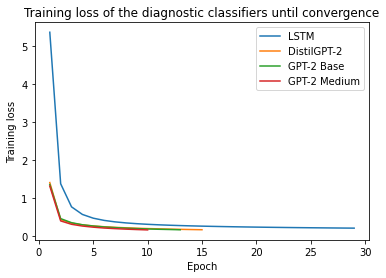

In [30]:
import matplotlib.pyplot as plt

lstm_x = list(range(1, (len(lstm_train_loss[:-4]) + 1)))
lstm_y = lstm_train_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_train_loss[:-4]) + 1)))
transformer_y = transformer_train_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_train_loss[:-4]) + 1)))
gpt_base_y = gpt_base_train_loss[:-4]
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_train_loss[:-4]) + 1)))
gpt_medium_y = gpt_medium_train_loss[:-4]
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss of the diagnostic classifiers until convergence')
plt.legend()
plt.show()

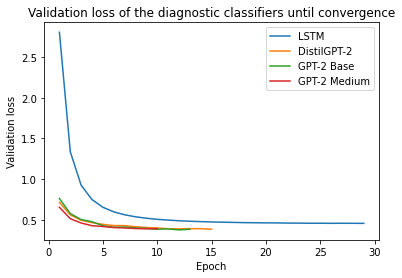

In [31]:
lstm_x = list(range(1, (len(lstm_valid_loss[:-4]) + 1)))
lstm_y = lstm_valid_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_valid_loss[:-4]) + 1)))
transformer_y = transformer_valid_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_valid_loss[:-4]) + 1)))
gpt_base_y = gpt_base_valid_loss[:-4]
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_valid_loss[:-4]) + 1)))
gpt_medium_y = gpt_medium_valid_loss[:-4]
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss of the diagnostic classifiers until convergence')
plt.legend()
plt.show()

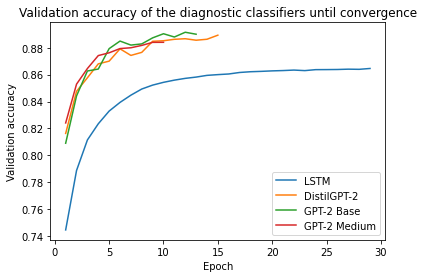

In [32]:
lstm_x = list(range(1, (len(lstm_valid_acc[:-4]) + 1)))
lstm_y = lstm_valid_acc[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_valid_acc[:-4]) + 1)))
transformer_y = transformer_valid_acc[:-4]
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_valid_acc[:-4]) + 1)))
gpt_base_y = gpt_base_valid_acc[:-4]
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_valid_acc[:-4]) + 1)))
gpt_medium_y = gpt_medium_valid_acc[:-4]
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy of the diagnostic classifiers until convergence')
plt.legend()
plt.show()

**Conclusion:**

We see that the Diagnostic Classifier performs very well (>85% validation and test accuracy) on the representations of all models. This indicates that both the LSTM and Transformer encode linguistic features into their representations. However, we see that Transformer models performer slightly better than LSTM models. We also see that the Transformer models start with a better validation accuracy in their first epochs, this seems to indicate that it is easier for a Diagnostic Classifier to learn from these representations without a lot of training time.

Interestingly, we see no correlation between model size and Diagnostic Classifier performance for the different Transformer models. This seems to indicate that there is no relation between model size and the extent to which Transformer models are able to capture linguistic features like POS-tags.

# Validating probing results with control tasks
In this section we will examine the faithfulness of the probing results using control tasks. We do this by creating a control task that predicts (pos_tag, token) pairs. We then train a Diagnostic Classifier on the hidden states of the Transformer model and the LSTM model with this control task.

We start by creating a control task. Then, we train our Diagnostic Classifier with this task on the encodings from the GPT-2 transformer and the encodings from the Gulordava LSTM model. Lastly, we compare this with the performance on the real task and calculate the selectivity.

First, we create a function that generates a new vocabulary that contains (pos_tag, token) pairs instead of a vocabulary that is solely based on the POS tag.

In [11]:
import random

# function that fetches the control tags
def fetch_control_tags(ud_parses: List[TokenList], pos_vocab_length, control_vocab=None) -> Tensor:
    # check if the vocabulary is None
    if control_vocab is None:
        # create a new vocab
        control_vocab = defaultdict()
    
    # create a list of tags from the input
    all_tags = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:    
        # loop over the words in the parsed sentence
        for word in sentence:
            # get the token of the word
            token = word['form']
            
            # check if the token does not exist in the vocabulary
            if token not in control_vocab:
                # create a new entry, which is a random number in the range of the pos_vocab_length
                control_vocab[token] = random.randrange(pos_vocab_length)
            
            # add tag to the tags list
            all_tags.append(torch.tensor(control_vocab[token]))
    
    # stack the tags into a tensor
    all_tags = torch.stack(all_tags, dim=0)
    
    # return the tags and vocabulary
    return all_tags, control_vocab

Secondly, we create a new version of our data creation function.

In [12]:
# function that creates the control data
def create_control_data(filename: str, lm, w2i, pos_vocab_length, pos_vocab=None, cut_off=None):
    ud_parses = parse_corpus(filename)
    if cut_off is not None:
        ud_parses = ud_parses[:cut_off]
    
    sen_reps = fetch_sen_reps(ud_parses, lm, w2i)
    pos_tags, pos_vocab = fetch_control_tags(ud_parses, pos_vocab_length, control_vocab=pos_vocab)
    
    return sen_reps, pos_tags, pos_vocab

In [13]:
# function to get the correct control data for each of the models
def create_pos_control_data(pos_vocab_length, model_used='Transformer'):
    # check which model to use
    if (model_used == 'Transformer'):
        lm = transformer_model
        w2i = transformer_tokenizer
    elif (model_used == 'GPT2_Base'):
        lm = gpt_base_model
        w2i = gpt_base_tokenizer
    elif (model_used == 'GPT2_Medium'):
        lm = gpt_medium_model
        w2i = gpt_medium_tokenizer
    else:
        lm = lstm
        w2i = vocab
    use_sample = False

    train_x, train_y, train_vocab = create_control_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        lm, 
        w2i,
        pos_vocab_length,
        cut_off=30000
    )

    dev_x, dev_y, _ = create_control_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
        lm, 
        w2i,
        pos_vocab_length,
        pos_vocab=train_vocab
    )

    test_x, test_y, _ = create_control_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
        lm,
        w2i,
        pos_vocab_length,
        pos_vocab=train_vocab
    )
    
    # return the data
    return train_x, train_y, dev_x, dev_y, test_x, test_y

In [14]:
from sklearn.metrics import accuracy_score
import json

# function that trains the DC on the control task and returns the metrics
def train_test_control_dc(vocab_length, model_used='Transformer', batch_size=24, max_epochs=2, save_results=True):
    # get the data for the model
    print('Loading data..')
    train_x, train_y, dev_x, dev_y, test_x, test_y = create_pos_control_data(vocab_length, model_used)
    print('Data loaded')
    
    # combine train and validation datasets
    x_train = torch.cat((train_x, dev_x), dim=0)
    y_train = torch.cat((train_y, dev_y), dim=0)
    
    # train the diagnostic classifier
    print('Starting training..')
    trained_dc = train_dc(DiagnosticClassifier, train_x[:30000].cpu(), 
                          train_y[:30000].cpu(), dev_x.cpu(), dev_y.cpu(), 
                          device, batch_size=batch_size, max_epochs=max_epochs)
    print('Training finished')
    
    # get the DC data
    train_loss = trained_dc.history[:, 'train_loss']
    valid_loss = trained_dc.history[:, 'valid_loss']
    valid_acc = trained_dc.history[:, 'valid_acc']
    
    # run the test data through the model
    test_preds = trained_dc.predict(test_x.cpu())
    test_acc = accuracy_score(test_y.cpu(), test_preds)
    
    if save_results:
        # save the results
        print('Saving results..')
        data = {}
        data['train_loss'] = train_loss
        data['valid_loss'] = valid_loss
        data['valid_acc'] = valid_acc
        data['test_acc'] = test_acc
        with open('model_results/' + model_used.lower() + '_control_dc.txt', 'w') as outfile:
            json.dump(data, outfile)
        print('Results saved')
    
    # return the measures 
    return train_loss, valid_loss, valid_acc, test_acc, vocab_length

Now we can evaluate our Diagnostic Classifier on the new control task.

In [15]:
# train the transformer model
(transformer_control_train_loss, 
 transformer_control_valid_loss, 
 transformer_control_valid_acc, 
 transformer_control_test_acc, 
 transformer_control_vocab_length) = train_test_control_dc(transformer_vocab_length, 
                                                           model_used='Transformer', 
                                                           batch_size=24, 
                                                           max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.5778       0.3692        2.1261  11.4270
      2        1.8202       0.4190        1.9814  11.3750
      3        1.6780       0.4500        1.9079  11.3290
      4        1.5919       0.4631        1.8557  11.3414
      5        1.5347       0.4757        1.8146  11.3240
      6        1.4898       0.4765        1.8131  11.3110
      7        1.4579       0.4919        1.7941  11.3300
      8        1.4310       0.4901        1.7920  11.2817
      9        1.4079       0.4927        1.7802  11.3050
     10        1.3890       0.4925        1.7889  11.3077
     11        1.3729       0.4952        1.7915  11.3180
Stopping since valid_loss has not improved in the last 3 epochs.
Training finished
Saving results..
Results saved


In [20]:
#import json

# or load the results from an earlier run
#with open('model_results/transformer_control_dc.txt') as json_file:
    #data = json.load(json_file)
    #transformer_control_train_loss = data['train_loss']
    #transformer_control_valid_loss = data['valid_loss']
    #transformer_control_valid_acc = data['valid_acc']
    #transformer_control_test_acc = data['test_acc']

In [16]:
# train the GPT-2 Base model
(gpt_base_control_train_loss, 
 gpt_base_control_valid_loss, 
 gpt_base_control_valid_acc, 
 gpt_base_control_test_acc, 
 gpt_base_control_vocab_length) = train_test_control_dc(gpt_base_vocab_length, 
                                                        model_used='GPT_Base', 
                                                        batch_size=24, 
                                                        max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        6.3138       0.3063        4.3811  10.2904
      2        2.9698       0.3489        3.0040  10.0020
      3        2.3035       0.3773        2.4961  10.0040
      4        2.0216       0.4005        2.2409  9.9920
      5        1.8670       0.4197        2.0905  10.0010
      6        1.7689       0.4352        1.9994  10.0083
      7        1.7008       0.4456        1.9388  10.0020
      8        1.6504       0.4552        1.8956  9.9870
      9        1.6115       0.4633        1.8654  10.0580
     10        1.5803       0.4698        1.8449  9.9910
     11        1.5544       0.4732        1.8265  10.0000
     12        1.5324       0.4777        1.8120  9.9950
     13        1.5132       0.4812        1.8039  10.0140
     14        1.4967       0.4831        1.7920  9.9910
     15        1.4819       0.

In [21]:
#import json

# or load the results from an earlier run
#with open('model_results/gpt_base_control_dc.txt') as json_file:
    #data = json.load(json_file)
    #gpt_base_control_train_loss = data['train_loss']
    #gpt_base_control_valid_loss = data['valid_loss']
    #gpt_base_control_valid_acc = data['valid_acc']
    #gpt_base_control_test_acc = data['test_acc']

In [16]:
# train the GPT-2 Medium model
(gpt_medium_control_train_loss, 
 gpt_medium_control_valid_loss, 
 gpt_medium_control_valid_acc, 
 gpt_medium_control_test_acc, 
 gpt_medium_control_vocab_length) = train_test_control_dc(gpt_medium_vocab_length, 
                                                          model_used='GPT_Medium', 
                                                          batch_size=24, 
                                                          max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        6.3239       0.3206        4.3743  10.3787
      2        2.9698       0.3522        2.9932  9.9750
      3        2.3055       0.3825        2.4866  10.0670
      4        2.0260       0.4044        2.2378  10.0480
      5        1.8735       0.4216        2.0926  10.0050
      6        1.7769       0.4352        2.0026  10.0120
      7        1.7096       0.4474        1.9407  9.9950
      8        1.6600       0.4541        1.9011  9.9980
      9        1.6218       0.4623        1.8704  9.9890
     10        1.5911       0.4693        1.8490  9.9800
     11        1.5658       0.4746        1.8315  10.0450
     12        1.5441       0.4798        1.8148  10.0050
     13        1.5256       0.4840        1.8072  10.0080
     14        1.5090       0.4863        1.7985  9.9850
     15        1.4946       0.4

In [22]:
#import json

# or load the results from an earlier run
#with open('model_results/gpt_medium_control_dc.txt') as json_file:
    #data = json.load(json_file)
    #gpt_medium_control_train_loss = data['train_loss']
    #gpt_medium_control_valid_loss = data['valid_loss']
    #gpt_medium_control_valid_acc = data['valid_acc']
    #gpt_medium_control_test_acc = data['test_acc']

In [15]:
# train the LSTM model
(lstm_control_train_loss, 
 lstm_control_valid_loss, 
 lstm_control_valid_acc, 
 lstm_control_test_acc, 
 lstm_control_vocab_length) = train_test_control_dc(lstm_vocab_length, 
                                                    model_used='LSTM', 
                                                    batch_size=24, 
                                                    max_epochs=200)

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        6.3397       0.3214        4.4066  10.3022
      2        3.0023       0.3666        3.0197  10.0750
      3        2.3236       0.3914        2.4980  9.9910
      4        2.0378       0.4073        2.2411  10.0170
      5        1.8817       0.4242        2.0914  9.9970
      6        1.7826       0.4391        1.9986  9.9780
      7        1.7136       0.4493        1.9385  9.9982
      8        1.6626       0.4589        1.8978  9.9960
      9        1.6232       0.4682        1.8658  10.0050
     10        1.5915       0.4731        1.8418  9.9850
     11        1.5654       0.4784        1.8249  9.9890
     12        1.5431       0.4827        1.8130  10.0520
     13        1.5238       0.4876        1.8028  10.0020
     14        1.5069       0.4906        1.7902  9.9890
     15        1.4918       0.492

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/lstm_control_dc.txt') as json_file:
    #data = json.load(json_file)
    #lstm_control_train_loss = data['train_loss']
    #lstm_control_valid_loss = data['valid_loss']
    #lstm_control_valid_acc = data['valid_acc']
    #lstm_control_test_acc = data['test_acc']

Now we can compare the results of the four different diagnostic classifiers on the control task.

In [23]:
print('DistilGPT-2 diagnostic classifier on control task after convergence:')
print(f'Train loss = {transformer_control_train_loss[-4]:.4f}')
print(f'Validation loss = {transformer_control_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {transformer_control_valid_acc[-4]:.4f}')
print(f'Test accuracy = {transformer_control_test_acc:.4f}')

DistilGPT-2 diagnostic classifier on control task after convergence:
Train loss = 1.4079
Validation loss = 1.7802
Validation accuracy = 0.4927
Test accuracy = 0.4898


In [24]:
print('GPT-2 Base diagnostic classifier on control task after convergence:')
print(f'Train loss = {gpt_base_control_train_loss[-4]:.4f}')
print(f'Validation loss = {gpt_base_control_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {gpt_base_control_valid_acc[-4]:.4f}')
print(f'Test accuracy = {gpt_base_control_test_acc:.4f}')

GPT-2 Base diagnostic classifier on control task after convergence:
Train loss = 1.3689
Validation loss = 1.7494
Validation accuracy = 0.5052
Test accuracy = 0.5045


In [25]:
print('GPT-2 Medium diagnostic classifier on control task after convergence:')
print(f'Train loss = {gpt_medium_control_train_loss[-4]:.4f}')
print(f'Validation loss = {gpt_medium_control_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {gpt_medium_control_valid_acc[-4]:.4f}')
print(f'Test accuracy = {gpt_medium_control_test_acc:.4f}')

GPT-2 Medium diagnostic classifier on control task after convergence:
Train loss = 1.3926
Validation loss = 1.7627
Validation accuracy = 0.5022
Test accuracy = 0.4961


In [26]:
print('LSTM diagnostic classifier on control task after convergence:')
print(f'Train loss = {lstm_control_train_loss[-4]:.4f}')
print(f'Validation loss = {lstm_control_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {lstm_control_valid_acc[-4]:.4f}')
print(f'Test accuracy = {lstm_control_test_acc:.4f}')

LSTM diagnostic classifier on control task after convergence:
Train loss = 1.3730
Validation loss = 1.7479
Validation accuracy = 0.5122
Test accuracy = 0.5038


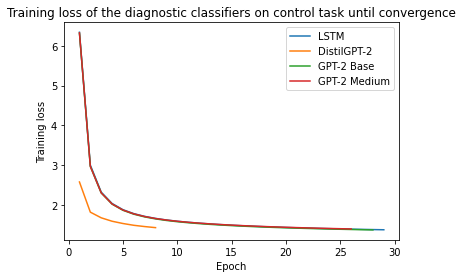

In [27]:
import matplotlib.pyplot as plt

lstm_x = list(range(1, (len(lstm_control_train_loss[:-4]) + 1)))
lstm_y = lstm_control_train_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_control_train_loss[:-4]) + 1)))
transformer_y = transformer_control_train_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_control_train_loss[:-4]) + 1)))
gpt_base_y = gpt_base_control_train_loss[:-4]
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_control_train_loss[:-4]) + 1)))
gpt_medium_y = gpt_medium_control_train_loss[:-4]
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss of the diagnostic classifiers on control task until convergence')
plt.legend()
plt.show()

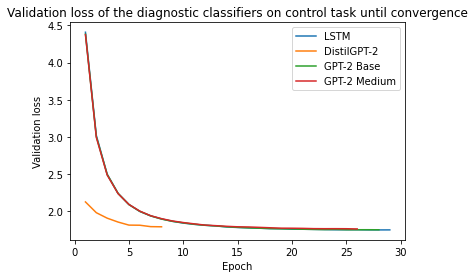

In [28]:
lstm_x = list(range(1, (len(lstm_control_valid_loss[:-4]) + 1)))
lstm_y = lstm_control_valid_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_control_valid_loss[:-4]) + 1)))
transformer_y = transformer_control_valid_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_control_valid_loss[:-4]) + 1)))
gpt_base_y = gpt_base_control_valid_loss[:-4]
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_control_valid_loss[:-4]) + 1)))
gpt_medium_y = gpt_medium_control_valid_loss[:-4]
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss of the diagnostic classifiers on control task until convergence')
plt.legend()
plt.show()

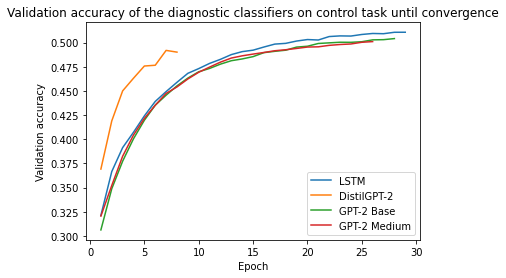

In [29]:
lstm_x = list(range(1, (len(lstm_control_valid_acc[:-4]) + 1)))
lstm_y = lstm_control_valid_acc[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_control_valid_acc[:-4]) + 1)))
transformer_y = transformer_control_valid_acc[:-4]
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_control_valid_acc[:-4]) + 1)))
gpt_base_y = gpt_base_control_valid_acc[:-4]
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_control_valid_acc[:-4]) + 1)))
gpt_medium_y = gpt_medium_control_valid_acc[:-4]
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy of the diagnostic classifiers on control task until convergence')
plt.legend()
plt.show()

Now we will look at the selectivity of our Diagnostic Classifiers.

In [30]:
print('DistilGPT-2 diagnostic classifier:')
print(f'Real task test accuracy = {transformer_test_acc:.4f}')
print(f'Control task test accuracy = {transformer_control_test_acc:.4f}')
print(f'Selectivity = {(transformer_test_acc - transformer_control_test_acc):.4f}')

DistilGPT-2 diagnostic classifier:
Real task test accuracy = 0.8852
Control task test accuracy = 0.4898
Selectivity = 0.3954


In [31]:
print('GPT-2 Base diagnostic classifier:')
print(f'Real task test accuracy = {gpt_base_test_acc:.4f}')
print(f'Control task test accuracy = {gpt_base_control_test_acc:.4f}')
print(f'Selectivity = {(gpt_base_test_acc - gpt_base_control_test_acc):.4f}')

GPT-2 Base diagnostic classifier:
Real task test accuracy = 0.8907
Control task test accuracy = 0.5045
Selectivity = 0.3862


In [32]:
print('GPT-2 Medium diagnostic classifier:')
print(f'Real task test accuracy = {gpt_medium_test_acc:.4f}')
print(f'Control task test accuracy = {gpt_medium_control_test_acc:.4f}')
print(f'Selectivity = {(gpt_medium_test_acc - gpt_medium_control_test_acc):.4f}')

GPT-2 Medium diagnostic classifier:
Real task test accuracy = 0.8844
Control task test accuracy = 0.4961
Selectivity = 0.3883


In [33]:
print('LSTM diagnostic classifier:')
print(f'Real task test accuracy = {lstm_test_acc:.4f}')
print(f'Control task test accuracy = {lstm_control_test_acc:.4f}')
print(f'Selectivity = {(lstm_test_acc - lstm_control_test_acc):.4f}')

LSTM diagnostic classifier:
Real task test accuracy = 0.8663
Control task test accuracy = 0.5038
Selectivity = 0.3624


**Conclusion:**

We see that the Diagnostic Classifier performs very poorly on the control task (around 50% validation and test accuracy) on the representations of all models. This indicates that the good performance on the real task does not come from the fact that the Diagnostic Classifier is strong enough to learn any mapping. This is backed up by the high selectivity that we see for all Diagnostic Classifiers (around 35-40%). Therefore, the good performance on the real task comes from the fact that the Transformer and LSTM models are able to capture linguistic features like POS-tags in their hidden states.

Again, we see no correlation between model size and Diagnostic Classifier performance on the control task for the different Transformer models. Also, the selectivity is almost the same for all Transformer models. Therefore, we can again conclude that there is no correlation between Transformer model size and performance on this task.

We see that the Transformer models slightly outperform the LSTM in terms of selectivity. This might indicate that the Transformer models are slightly better at capturing linguistic features like POS-tags in their embeddings.

# Notion of syntactic structure
In this section we will examine whether transformer models have a stronger notion of syntactic structure than recurrent models? We do this by applying our structural probe on the representations of our four different models (DistilGPT-2, GPT-2 Base, GPT-2 Medium, and LSTM).

We start by training our structural probe on the encodings of the different models. We then compare the performance of the probe on both models.

In [ ]:
# function to save the results
def save_probe_results(name, train_loss, valid_loss, valid_uuas, test_loss, test_uuas):
    print('Saving results..')
    data = {}
    data['train_loss'] = train_loss
    data['valid_loss'] = valid_loss
    data['valid_uuas'] = valid_uuas
    data['test_loss'] = test_loss
    data['test_uuas'] = test_uuas
    with open('model_results/' + name + '_probe.txt', 'w') as outfile:
        json.dump(data, outfile)
    print('Results saved')

In [ ]:
# create the datasets for DistilGPT-2
train_y, train_x = init_corpus('data/en_ewt-ud-train.conllu', transformer_model, transformer_tokenizer)
dev_y, dev_x = init_corpus('data/en_ewt-ud-dev.conllu', transformer_model, transformer_tokenizer)
test_y, test_x = init_corpus('data/en_ewt-ud-test.conllu', transformer_model, transformer_tokenizer)

# train the probe for DistilGPT-2
(_, transformer_train_loss, 
 transformer_valid_loss, 
 transformer_valid_uuas, 
 transformer_test_loss, 
 transformer_test_uuas) = train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, emb_dim=768, batch_size=24, epochs=50)

# save the results
save_probe_results('transformer', transformer_train_loss, transformer_valid_loss, transformer_valid_uuas, 
                   transformer_test_loss, transformer_test_uuas)

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/transformer_probe.txt') as json_file:
    #data = json.load(json_file)
    #transformer_train_loss = data['train_loss']
    #transformer_valid_loss = data['valid_loss']
    #transformer_valid_uuas = data['valid_uuas']
    #transformer_test_loss = data['test_loss']
    #transformer_test_uuas = data['test_uuas']

In [ ]:
# create the datasets for GPT-2 Base
train_y, train_x = init_corpus('data/en_ewt-ud-train.conllu', gpt_base_model, gpt_base_tokenizer)
dev_y, dev_x = init_corpus('data/en_ewt-ud-dev.conllu', gpt_base_model, gpt_base_tokenizer)
test_y, test_x = init_corpus('data/en_ewt-ud-test.conllu', gpt_base_model, gpt_base_tokenizer)

# train the probe for GPT-2 Base
(_, gpt_base_train_loss, 
 gpt_base_valid_loss, 
 gpt_base_valid_uuas, 
 gpt_base_test_loss, 
 gpt_base_test_uuas) = train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, emb_dim=768, batch_size=24, epochs=50)

# save the results
save_probe_results('gpt2_base', gpt_base_train_loss, gpt_base_valid_loss, gpt_base_valid_uuas, 
                   gpt_base_test_loss, gpt_base_test_uuas)

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/gpt2_base_probe.txt') as json_file:
    #data = json.load(json_file)
    #gpt_base_train_loss = data['train_loss']
    #gpt_base_valid_loss = data['valid_loss']
    #gpt_base_valid_uuas = data['valid_uuas']
    #gpt_base_test_loss = data['test_loss']
    #gpt_base_test_uuas = data['test_uuas']

In [ ]:
# create the datasets for GPT-2 Medium
train_y, train_x = init_corpus('data/en_ewt-ud-train.conllu', gpt_medium_model, gpt_medium_tokenizer)
dev_y, dev_x = init_corpus('data/en_ewt-ud-dev.conllu', gpt_medium_model, gpt_medium_tokenizer)
test_y, test_x = init_corpus('data/en_ewt-ud-test.conllu', gpt_medium_model, gpt_medium_tokenizer)

# train the probe for GPT-2 Medium
(_, gpt_medium_train_loss, 
 gpt_medium_valid_loss, 
 gpt_medium_valid_uuas, 
 gpt_medium_test_loss, 
 gpt_medium_test_uuas) = train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, emb_dim=1024, batch_size=24, epochs=50)

# save the results
save_probe_results('gpt2_medium', gpt_medium_train_loss, gpt_medium_valid_loss, gpt_medium_valid_uuas, 
                   gpt_medium_test_loss, gpt_medium_test_uuas)

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/gpt2_medium_probe.txt') as json_file:
    #data = json.load(json_file)
    #gpt_medium_train_loss = data['train_loss']
    #gpt_medium_valid_loss = data['valid_loss']
    #gpt_medium_valid_uuas = data['valid_uuas']
    #gpt_medium_test_loss = data['test_loss']
    #gpt_medium_test_uuas = data['test_uuas']

In [ ]:
# create the datasets for LSTM
train_y, train_x = init_corpus('data/en_ewt-ud-train.conllu', lstm, w2i)
dev_y, dev_x = init_corpus('data/en_ewt-ud-dev.conllu', lstm, w2i)
test_y, test_x = init_corpus('data/en_ewt-ud-test.conllu', lstm, w2i)

# train the probe for LSTM
(_, lstm_train_loss, 
 lstm_valid_loss, 
 lstm_valid_uuas, 
 lstm_test_loss, 
 lstm_test_uuas) = train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, emb_dim=650, batch_size=24, epochs=50)

# save the results
save_probe_results('lstm', lstm_train_loss, lstm_valid_loss, lstm_valid_uuas, 
                   lstm_test_loss, lstm_test_uuas)

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/lstm_probe.txt') as json_file:
    #data = json.load(json_file)
    #lstm_train_loss = data['train_loss']
    #lstm_valid_loss = data['valid_loss']
    #lstm_valid_uuas = data['valid_uuas']
    #lstm_test_loss = data['test_loss']
    #lstm_test_uuas = data['test_uuas']

Now we can compare the results of the four different structural probes.

In [ ]:
print('DistilGPT-2 structural probe after 50 epochs:')
print(f'Train loss = {transformer_train_loss[-1]:.4f}')
print(f'Validation loss = {transformer_valid_loss[-1]:.4f}')
print(f'Validation UUAS = {transformer_valid_uuas[-1]:.4f}')
print(f'Test loss = {transformer_test_loss:.4f}')
print(f'Test UUAS = {transformer_test_uuas:.4f}')

In [ ]:
print('GPT-2 Base structural probe after 50 epochs:')
print(f'Train loss = {gpt_base_train_loss[-1]:.4f}')
print(f'Validation loss = {gpt_base_valid_loss[-1]:.4f}')
print(f'Validation UUAS = {gpt_base_valid_uuas[-1]:.4f}')
print(f'Test loss = {gpt_base_test_loss:.4f}')
print(f'Test UUAS = {gpt_base_test_uuas:.4f}')

In [ ]:
print('GPT-2 Medium structural probe after 50 epochs:')
print(f'Train loss = {gpt_medium_train_loss[-1]:.4f}')
print(f'Validation loss = {gpt_medium_valid_loss[-1]:.4f}')
print(f'Validation UUAS = {gpt_medium_valid_uuas[-1]:.4f}')
print(f'Test loss = {gpt_medium_test_loss:.4f}')
print(f'Test UUAS = {gpt_medium_test_uuas:.4f}')

In [ ]:
print('LSTM structural probe after 50 epochs:')
print(f'Train loss = {lstm_train_loss[-1]:.4f}')
print(f'Validation loss = {lstm_valid_loss[-1]:.4f}')
print(f'Validation UUAS = {lstm_valid_uuas[-1]:.4f}')
print(f'Test loss = {lstm_test_loss:.4f}')
print(f'Test UUAS = {lstm_test_uuas:.4f}')

In [ ]:
import matplotlib.pyplot as plt

lstm_x = list(range(1, (len(lstm_train_loss) + 1)))
lstm_y = lstm_train_loss
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_train_loss) + 1)))
transformer_y = transformer_train_loss
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_train_loss) + 1)))
gpt_base_y = gpt_base_train_loss
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_train_loss) + 1)))
gpt_medium_y = gpt_medium_train_loss
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss of the structural probes after 50 epochs')
plt.legend()
plt.show()

In [ ]:
lstm_x = list(range(1, (len(lstm_valid_loss) + 1)))
lstm_y = lstm_valid_loss
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_valid_loss) + 1)))
transformer_y = transformer_valid_loss
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_valid_loss) + 1)))
gpt_base_y = gpt_base_valid_loss
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_valid_loss) + 1)))
gpt_medium_y = gpt_medium_valid_loss
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss of the structural probes after 50 epochs')
plt.legend()
plt.show()

In [ ]:
lstm_x = list(range(1, (len(lstm_valid_uuas) + 1)))
lstm_y = lstm_valid_uuas
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_valid_uuas) + 1)))
transformer_y = transformer_valid_uuas
plt.plot(transformer_x, transformer_y, label = "DistilGPT-2")

gpt_base_x = list(range(1, (len(gpt_base_valid_uuas) + 1)))
gpt_base_y = gpt_base_valid_uuas
plt.plot(gpt_base_x, gpt_base_y, label = "GPT-2 Base")

gpt_medium_x = list(range(1, (len(gpt_medium_valid_uuas) + 1)))
gpt_medium_y = gpt_medium_valid_uuas
plt.plot(gpt_medium_x, gpt_medium_y, label = "GPT-2 Medium")

plt.xlabel('Epoch')
plt.ylabel('Validation UUAS')
plt.title('Validation UUAS of the structural probes after 50 epochs')
plt.legend()
plt.show()

**Conclusion:**

**CONCLUSIE SCHRIJVEN**